In [75]:
import re
from io import StringIO
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import neurokit2 as nk

import mne

In [76]:
import json

p = {}
assets = Path("../assets/pilot")
for person_dir in assets.iterdir():
    info = person_dir / "info.json"
    with info.open("r") as file:
        data = json.load(file)
        full_name = f"{data['name']} {data['lastname']}"
        p[full_name] = data
    p[full_name]["eeg"] = {}
    for edf_file in person_dir.glob("*.edf"):
        p[full_name]["eeg"][edf_file.stem] = mne.io.read_raw_edf(edf_file, verbose=False, exclude=["event"]) \
            .rename_channels(lambda x: x.replace('EEG ', '')) \
            .set_montage(mne.channels.make_standard_montage("standard_1020"))

print("\n".join(p.keys()))

Zahra Ahmadi
Kian Darabi
Fatemeh Saleh
Fatemeh Sadeghian
Fatemeh Hosseini
Reyhaneh Hosseini
MohammadAli HesariNezhad
Mona Kaveh
Atousa Norouzian
Noura Tavakori


In [132]:
from datetime import datetime, timedelta
state_result = {}

for subject, data in p.items():
    state_durations = []
    state_names = []
    for file_name, eeg_data in data["eeg"].items():
        start = eeg_data.info['meas_date']
        end = start + timedelta(seconds=eeg_data.times[-1])
        duration = end - start
        state_names.append(file_name)
        state_durations.append(duration)
    state_order = sorted(range(len(state_durations)), key=lambda k: state_durations[k].total_seconds())
    state_result[subject] = {
        'states': [
            {
                'name': state_names[i],
                'duration': state_durations[i].total_seconds(),
                'start': state_order.index(i),
                'end': state_order.index(i) + 1
            } for i in state_order
        ]
    }

# import pprint
# pprint.pprint(state_result)

In [78]:
def parse_file(file_path):
    with open(file_path) as file:
        content = file.read()
    
    client_name = re.search(r'Client:\s*(.+?)\s*Channel Set:', content).group(1).strip()
    csv_part = content.split('\n\n')[2].strip()

    raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]
    eda, info = nk.eda_process(raw, sampling_rate=256, report=client_name)    
    return client_name, eda, info

In [79]:
def eda_plot_dashedsegments(
    eda_signals, ax, x_axis, onsets, peaks, half_recovery
):
    # Mark onsets, peaks, and half-recovery.
    onset_x_values = x_axis[onsets]
    onset_y_values = eda_signals["EDA_Phasic"][onsets].values
    peak_x_values = x_axis[peaks]
    peak_y_values = eda_signals["EDA_Phasic"][peaks].values
    halfr_x_values = x_axis[half_recovery]
    halfr_y_values = eda_signals["EDA_Phasic"][half_recovery].values

    end_onset = pd.Series(
        eda_signals["EDA_Phasic"][onsets].values, eda_signals["EDA_Phasic"][peaks].index
    )

    risetime_coord = []
    amplitude_coord = []
    halfr_coord = []

    for i in range(len(onsets)):
        # Rise time.
        start = (onset_x_values[i], onset_y_values[i])
        end = (peak_x_values[i], onset_y_values[i])
        risetime_coord.append((start, end))

    for i in range(len(peaks)):
        # SCR Amplitude.
        start = (peak_x_values[i], onset_y_values[i])
        end = (peak_x_values[i], peak_y_values[i])
        amplitude_coord.append((start, end))

    for i in range(len(half_recovery)):
        # Half recovery.
        end = (halfr_x_values[i], halfr_y_values[i])
        peak_x_idx = np.where(peak_x_values < halfr_x_values[i])[0][-1]
        start = (peak_x_values[peak_x_idx], halfr_y_values[i])
        halfr_coord.append((start, end))


    # Plot with matplotlib.
    # Mark onsets, peaks, and half-recovery.
    ax.scatter(
        x_axis[onsets],
        eda_signals["EDA_Phasic"][onsets],
        color="#FFA726",
        label="SCR - Onsets",
        zorder=2,
    )
    ax.scatter(
        x_axis[peaks],
        eda_signals["EDA_Phasic"][peaks],
        color="#1976D2",
        label="SCR - Peaks",
        zorder=2,
    )
    ax.scatter(
        x_axis[half_recovery],
        eda_signals["EDA_Phasic"][half_recovery],
        color="#FDD835",
        label="SCR - Half recovery",
        zorder=2,
    )

    ax.scatter(x_axis[end_onset.index], end_onset.values, alpha=0)

    return risetime_coord, amplitude_coord, halfr_coord

In [134]:
def plot_data(eda_signal, info, name, state_duration):
    peaks = np.where(eda_signals["SCR_Peaks"] == 1)[0]
    onsets = np.where(eda_signals["SCR_Onsets"] == 1)[0]
    half_recovery = np.where(eda_signals["SCR_Recovery"] == 1)[0]
    
    # clean peaks that do not have onsets
    if len(peaks) > len(onsets):
        peaks = peaks[1:]
    
    # Determine unit of x-axis.
    x_label = "Time (seconds)"
    x_axis = np.linspace(0, len(eda_signals) / info["sampling_rate"], len(eda_signals))
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 8))
    
    last_ax = fig.get_axes()[-1]
    last_ax.set_xlabel(x_label)
    
    # Plot cleaned and raw electrodermal activity.
    ax0.set_title("Raw and Cleaned Signal")
    fig.suptitle(f"Electrodermal Activity (EDA) - {name}", fontweight="bold")
    
    ax0.plot(x_axis, eda_signals["EDA_Raw"], color="#B0BEC5", label="Raw", zorder=1)
    ax0.plot(
        x_axis,
        eda_signals["EDA_Clean"],
        color="#9C27B0",
        label="Cleaned",
        linewidth=1.5,
        zorder=1,
    )
    ax0.legend(loc="upper right")
    
    # Plot skin conductance response.
    ax1.set_title("Skin Conductance Response (SCR)")
    
    # Plot Phasic.
    ax1.plot(
        x_axis,
        eda_signals["EDA_Phasic"],
        color="#E91E63",
        label="Phasic Component",
        linewidth=1.5,
        zorder=1,
    )
    
    # Mark segments.
    risetime_coord, amplitude_coord, halfr_coord = eda_plot_dashedsegments(
        eda_signals, ax1, x_axis, onsets, peaks, half_recovery
    )
    
    risetime = matplotlib.collections.LineCollection(
        risetime_coord, colors="#FFA726", linewidths=1, linestyle="dashed"
    )
    ax1.add_collection(risetime)
    
    amplitude = matplotlib.collections.LineCollection(
        amplitude_coord, colors="#1976D2", linewidths=1, linestyle="solid"
    )
    ax1.add_collection(amplitude)
    
    halfr = matplotlib.collections.LineCollection(
        halfr_coord, colors="#FDD835", linewidths=1, linestyle="dashed"
    )
    ax1.add_collection(halfr)
    ax1.legend(loc="upper right")
    
    # Plot Tonic.
    ax2.set_title("Skin Conductance Level (SCL)")
    ax2.plot(
        x_axis,
        eda_signals["EDA_Tonic"],
        color="#673AB7",
        label="Tonic Component",
        linewidth=1.5,
    )
    # ax2.axvline(x=50, ymin = 0.25, ymax = 0.75, linewidth = 4, linestyle ="--", color = 'red')
    ax2.legend(loc="upper right") 
    name = name.split('-')[-1].split('-')[0].strip()
    print(name)
    if name in state_result:
        states = state_result[name]['states']
        cumulative_duration = 0
        
        print(f"Checking results for {name}")
        print(f"Number of states: {len(states)}")
        
        for state_info in states:
            duration = state_info['duration']
            start_time = cumulative_duration
            cumulative_duration += duration
            pos_x = (start_time + cumulative_duration)/2
            print(f"State: {state_info['name']}, Duration: {duration}, Start: {start_time}, End: {cumulative_duration}")
            
            ax2.axvline(x=start_time, color="black", linestyle="--", label=f"{state_info['name']} start")
            ax2.axvline(x=cumulative_duration, color="red", linestyle="-.", label=f"{state_info['name']} end")
            # ax2.annotate(f"{state_info['name']} start", xy=((start_time+cumulative_duration)/2, 4), xytext=((start_time+cumulative_duration)/2, 4))
            ax2.text(pos_x, 0.35, f"state: {state_info['name']}", style ='italic', fontsize = 8, color ="green") 
        

    fig.savefig(f"../assets/bio-plots/{name}.png", dpi=300, bbox_inches="tight")

C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Zahra Ahmadi
Checking results for Zahra Ahmadi
Number of states: 3
State: t, Duration: 296.998, Start: 0, End: 296.998
State: rest, Duration: 301.998, Start: 296.998, End: 598.996
State: s, Duration: 309.998, Start: 598.996, End: 908.9939999999999


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Kian Darabi
Checking results for Kian Darabi
Number of states: 3
State: rest_, Duration: 224.998, Start: 0, End: 224.998
State: s, Duration: 321.998, Start: 224.998, End: 546.996
State: t, Duration: 323.998, Start: 546.996, End: 870.9939999999999


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Mohamadali Hesarinezhad


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Reihane Hosseini


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Reihane Hosseini


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Mona Kave


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Atousa Norouzian
Checking results for Atousa Norouzian
Number of states: 3
State: rest, Duration: 195.998, Start: 0, End: 195.998
State: t, Duration: 205.998, Start: 195.998, End: 401.996
State: s, Duration: 254.998, Start: 401.996, End: 656.9939999999999


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Fatemeh Sadeghian
Checking results for Fatemeh Sadeghian
Number of states: 3
State: t, Duration: 185.998, Start: 0, End: 185.998
State: s, Duration: 235.998, Start: 185.998, End: 421.996
State: rest, Duration: 244.998, Start: 421.996, End: 666.9939999999999


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Fatemeh Saleh
Checking results for Fatemeh Saleh
Number of states: 3
State: s_, Duration: 218.998, Start: 0, End: 218.998
State: t, Duration: 225.998, Start: 218.998, End: 444.996
State: rest, Duration: 246.998, Start: 444.996, End: 691.9939999999999


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\575108945.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Noura Tavakoli


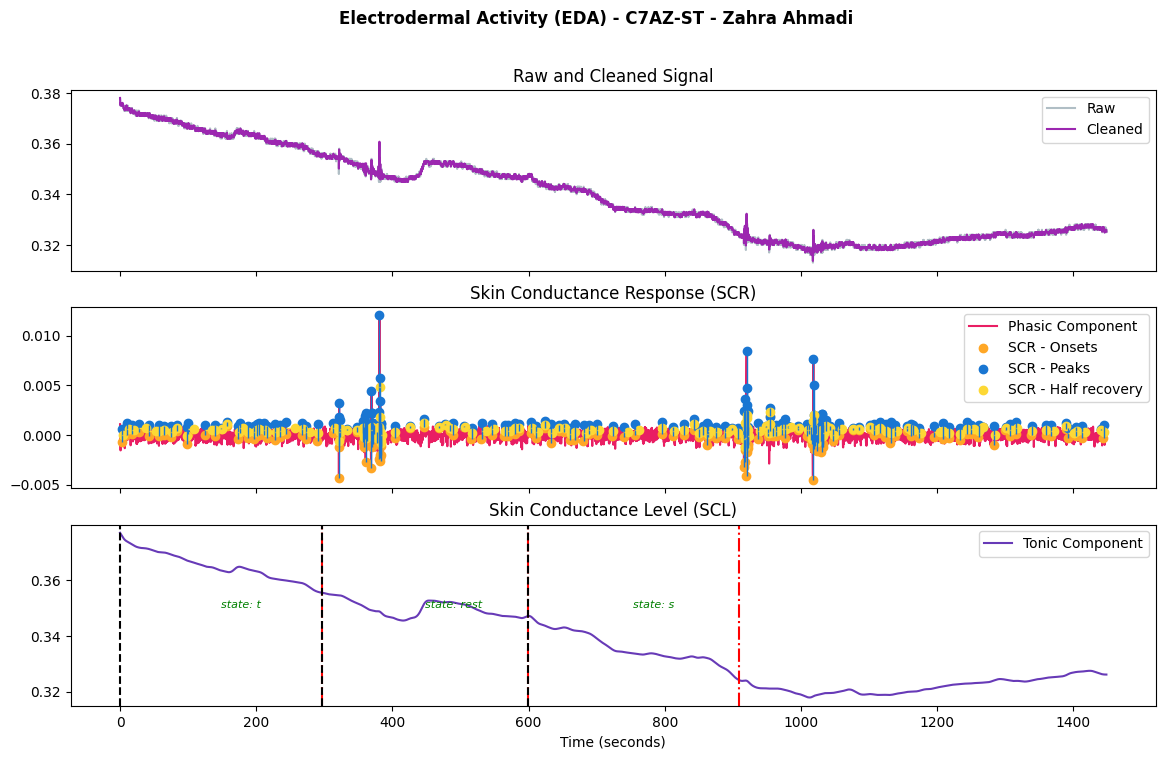

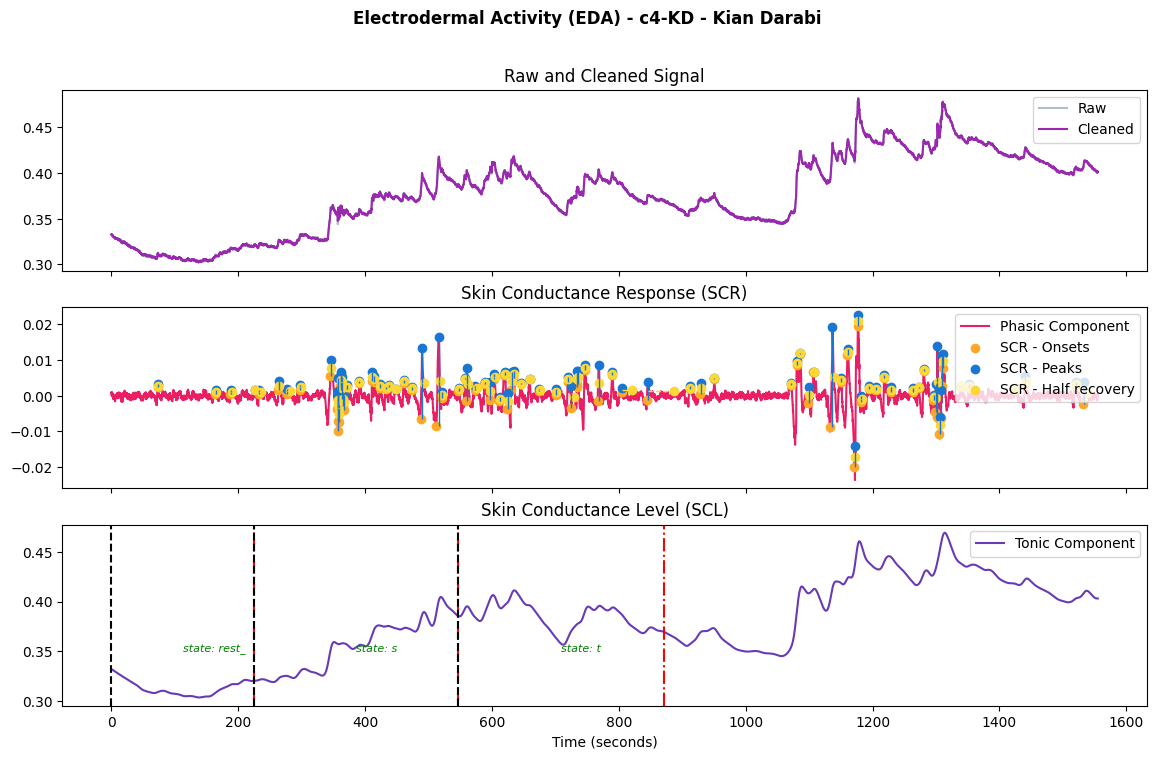

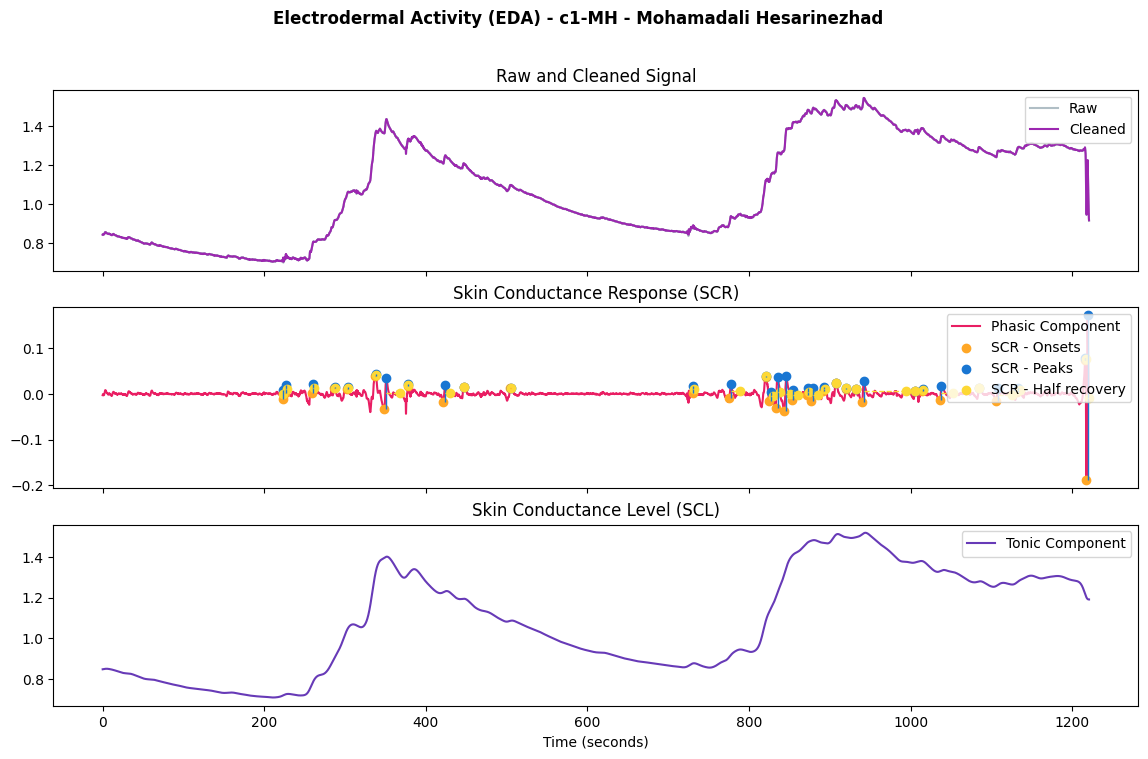

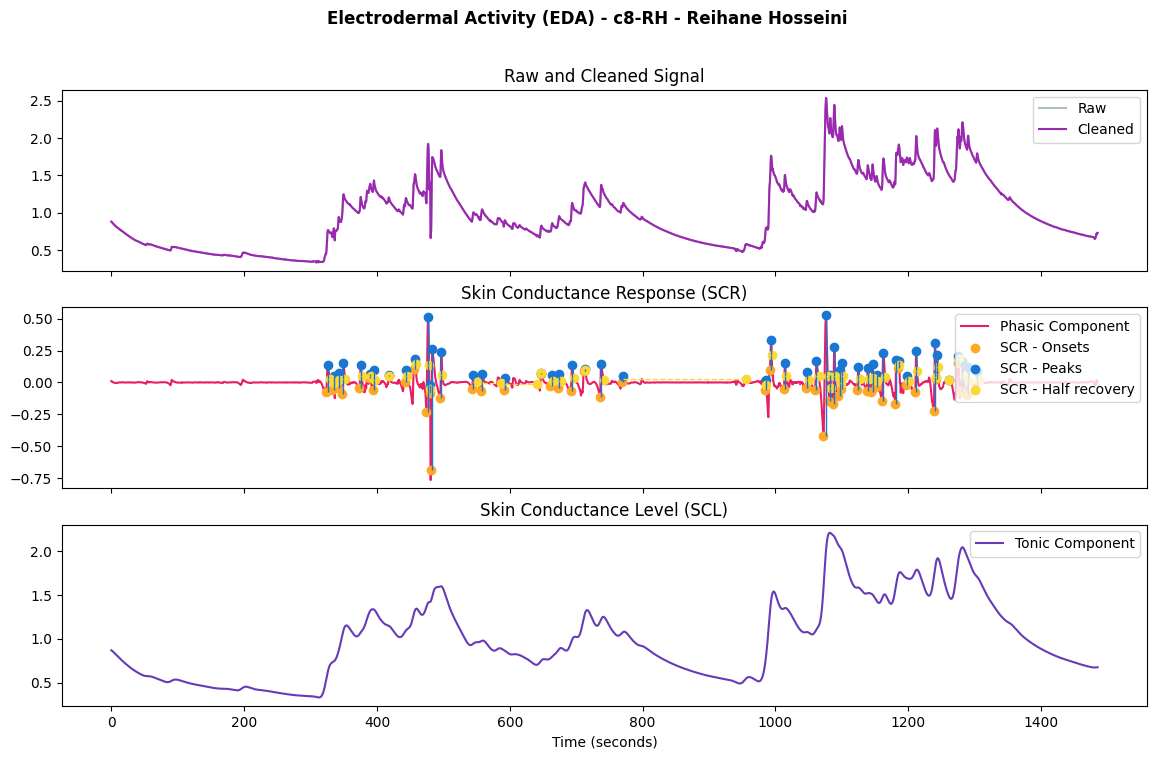

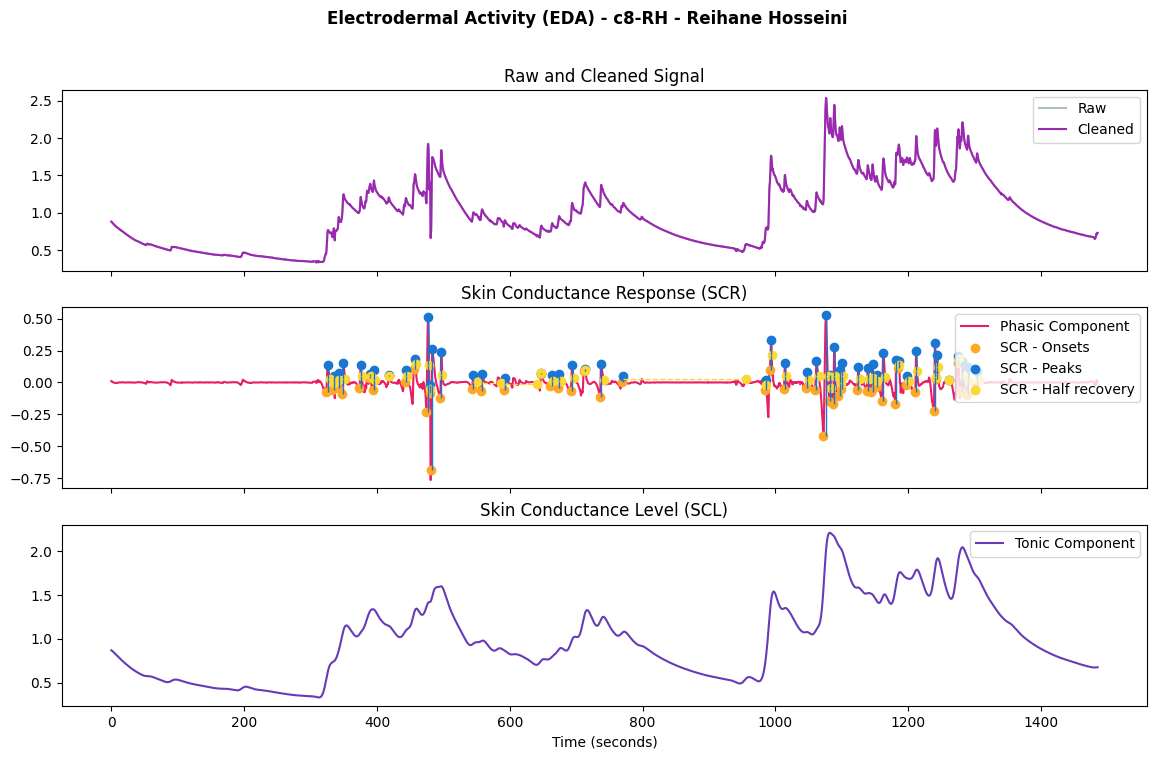

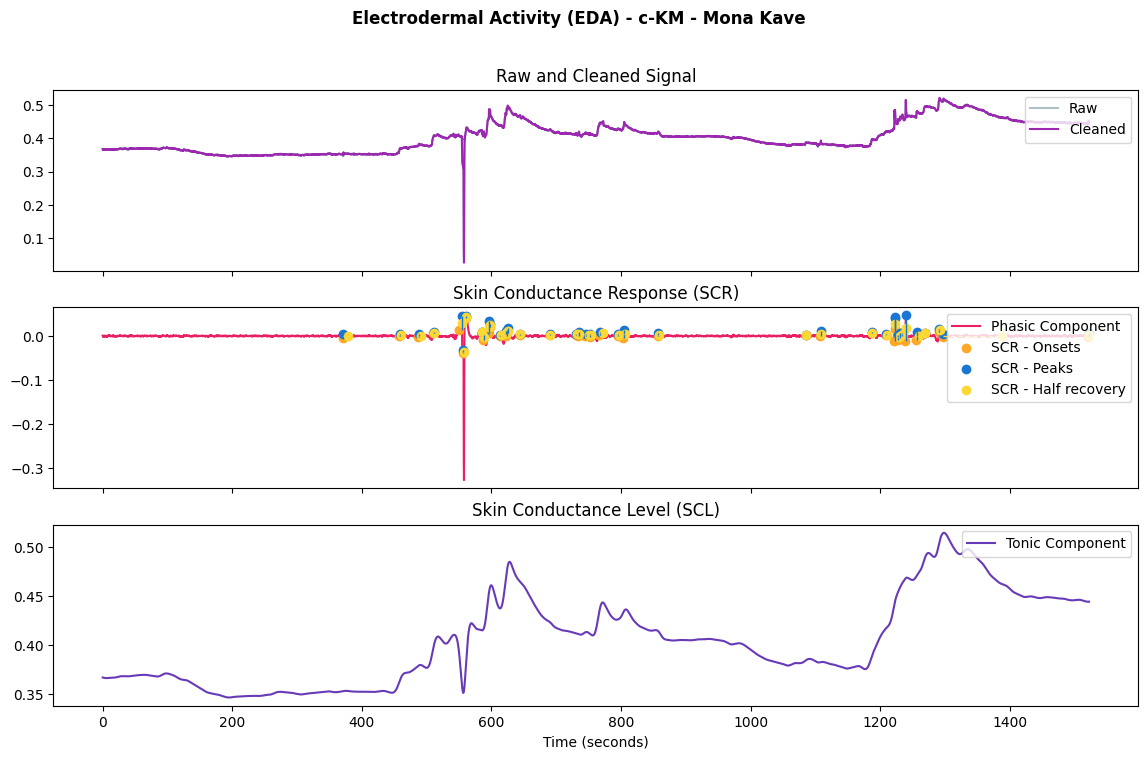

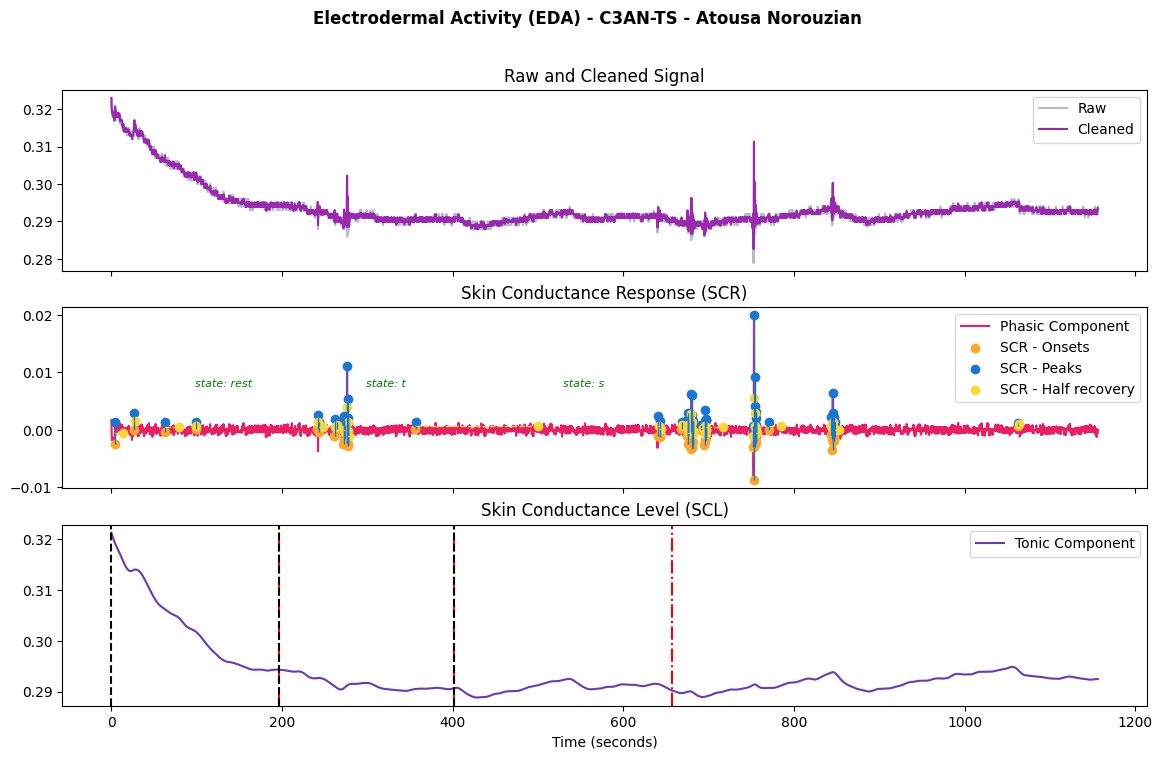

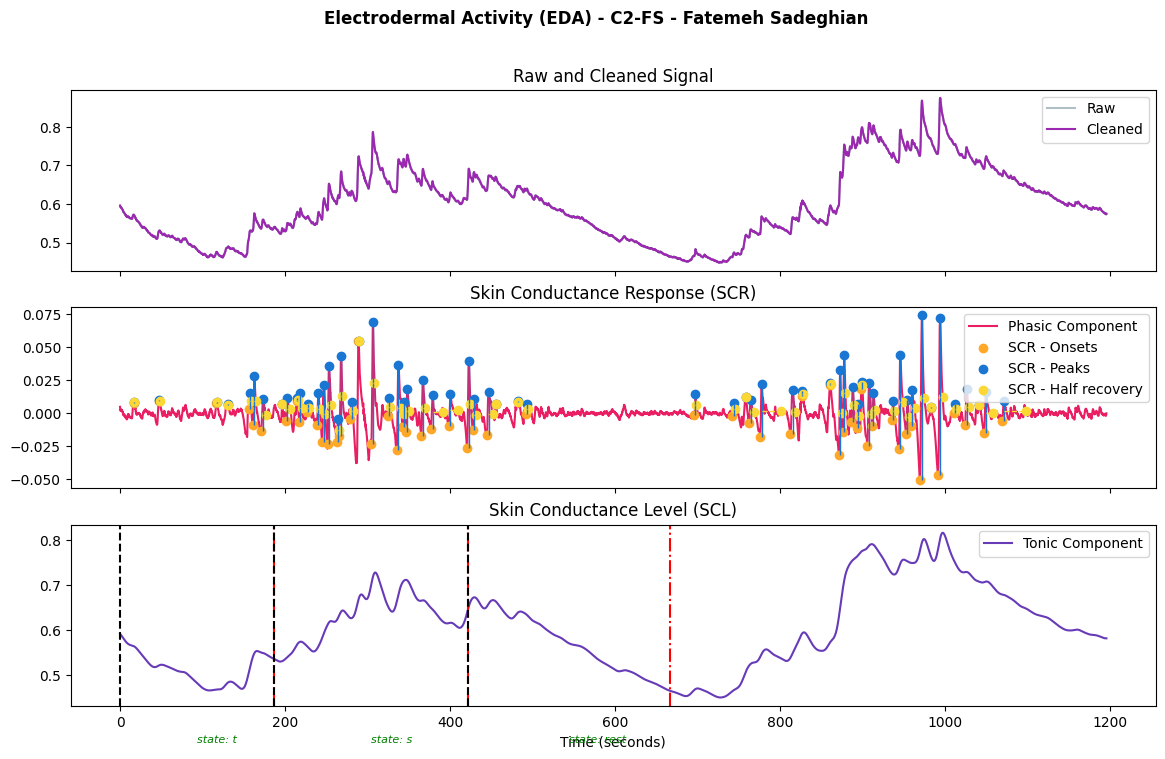

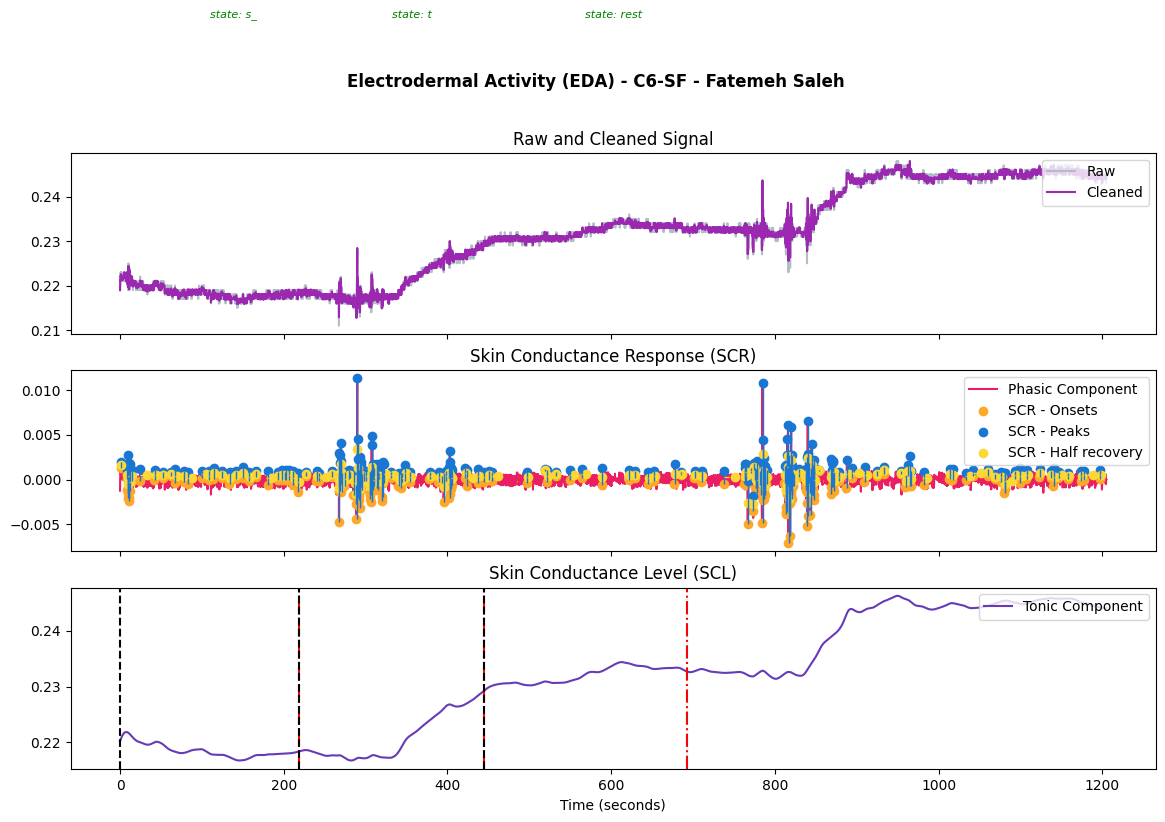

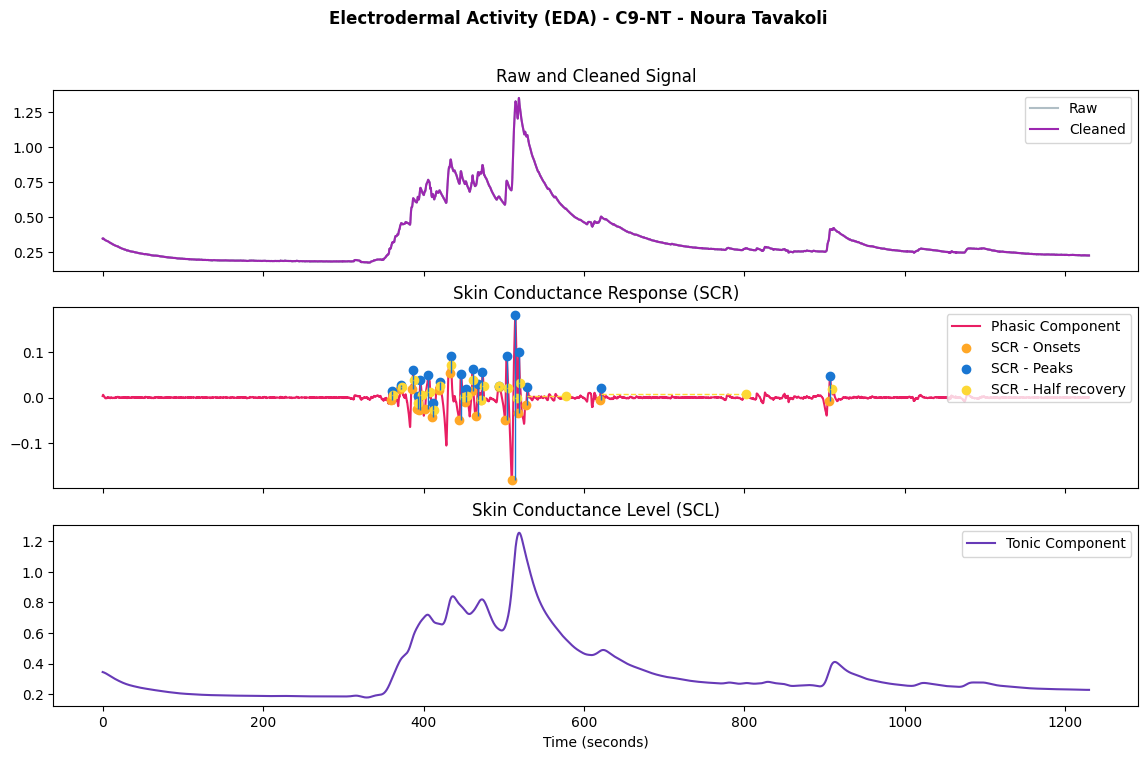

In [135]:
directory = "../assets/bio"
for file_name in Path(directory).iterdir():
    client_name, eda_signals, info = parse_file(file_name)
    plot_data(eda_signals, info, client_name, state_result)